# 100 Million Ratings with Spark on a Mac M1

<br>

Is it feasable to train a model on 100 million rows using nothing more than a common laptop? Let's find out. 

I've been refreshing Spark lately and wanted to give it a try on a dataset I wouldn't be able to deal with using non-big data tools such as Pandas and Numpy. I came across the dataset and the Netflix challenge it originates from some time ago, but have never really had any reason to work on it. Until now. I should also confess that I've been inspired by [Jared Pollack](https://www.linkedin.com/in/jaredpollack713/) from our discussion about it some time ago. 


The dataset can be downloaded through [this](https://www.kaggle.com/netflix-inc/netflix-prize-data) link.

[Conclusions](#conclusions) can be found at the end.



<br><br>


<a name="top"></a>

<br>


- [Prepare, Merge and Convert the Data to Parquet Format](#prepare_merge_convert)
    - [Prepare the Data](#prepare)
    - [Merge and Convert to Parquet Format](#convert_parquet)
- [Initial Exploratory Data Analysis](#initial_eda)
- [Feature Engineering](#FE)
- [Data Visualisation](#data_vis)
- [Machine Learning modelling](#ml-modelling)
    - [Get Baseline Results with Linear Regression](#baseline)
    - [Tune and Evaluate Multiple Regressors](#regressors)
- [Train the Best GBTRegressor on the Full Dataset](#best_model)
- [Which Features are most Important?](#feature_importance)
- [Conclusions](#conclusions)


<br><br>


In [1]:
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import date_format, datediff, to_date, udf, count
from pyspark.sql.functions import round as spark_round
from pyspark.ml.feature import FeatureHasher, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml import Pipeline

<a name="prepare_merge_convert"></a>


## [Prepare, Merge and Convert the Data to Parquet Format](#top)

The steps in this notebook assumes that the data has already been prepared and converted to a format more suitable for larger datasets. In case you haven't done that already, below scripts allows you to do that. 


<a name="prepare"></a>


### [Prepare the Data](#top)

The data comes ill-suited for analysis and needs to be prepared before taking any further steps. Run the cell below to create a file called `prepare_data.py` before executing the script `!python3 prepare_data.py`. Note that the script may take some time. 

In [45]:
%%writefile prepare_data.py
import os
import pandas as pd


if __name__ == "__main__":

    # Get file names
    d = "netflix-dataset"
    original_files = [f for f in os.listdir(d) if "combined_data" in f]

    # Loop over the original files and clean them up
    for filename in original_files:
        new_lines = []
        print(f"Working on file {filename}...")

        # Open the file filename, identify the movieID and add it to corresponding rows
        with open(f"netflix-dataset/{filename}") as data:
            for line in data:
                if ":\n" in line:
                    movieID = line.strip(":\n")
                else:
                    new_line = movieID+","+line
                    new_line = new_line.strip("\n").split(",")
                    new_lines.append(new_line)

            # Save to new file
            df = pd.DataFrame(new_lines)
            new_filename = "cleaned_" + filename.replace("txt", "csv")
            df.to_csv(f'cleaned-dataset/{new_filename}', header=False, index=False)

            print("Done!")
            print(f"Stored to {new_filename}")

Writing prepare_data.py


In [ ]:
# Uncomment to run the clean_data.py script
#!python3 prepare_data.py

<a name="convert_parquet"></a>

### [Merge and Convert to Parquet Format](#top)

Movie release year is not integrated in the main data files. In order to integrate it we have to load and merge it with the `movie_titles.csv` file. Then we convert it to Parquet format. Run the cell below to create the `convert_parquet.py` file before executing the following script. 


In [97]:
%%writefile convert_parquet.py
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, DateType, StringType, FloatType
import os


if __name__ == "__main__":

    # Input and output data paths
    data_csv = "cleaned-dataset-csv/cleaned_*.csv"
    movie_titles_path = "netflix-dataset/movie_titles.csv"
    output_data_parquet = "data-parquet"


    skip = False

    # If parquet file already exist, don't convert it. 
    if os.path.exists(output_data_parquet):
        skip = True


    if not skip:
        # Initiate SparkContext if currently not running
        try:
            sc = SparkContext(appName="CSV to Parquet")
            spark = SparkSession.builder.master("local").getOrCreate()
        except: 
            pass


    # Specify name and data type for each column and DataFrame
    schema_data = StructType([
        StructField("MovieID", IntegerType(), True),
        StructField("CustomerID", IntegerType(), True),
        StructField("Rating", FloatType(), True),
        StructField("RatingDate", DateType(), True)])
    schema_movies = StructType([
        StructField("MovieID", IntegerType(), True),
        StructField("YearOfRelease", IntegerType(), True)])


    # Load the datasets with the specified schemas
    if not skip:
        df = spark.read.csv("cleaned-dataset-csv/cleaned_*.csv", 
                            header=False, 
                            schema=schema_data)
        movie_titles = spark.read.csv(movie_titles_path, 
                                      schema=schema_movies)


    # Specify alias for the DataFrames to facilitate a join
    df = df.alias("df")
    movie_titles = movie_titles.alias("movie_titles")

    # Join the two DataFrames on MovieID. Select only columns of interest
    df = df.join(movie_titles,
                 df.MovieID == movie_titles.MovieID,
                 "left").select("df.*", "movie_titles.YearOfRelease")
    
    # Shuffle the data
    df = df.orderBy(rand())

    # Write to Parquet
    if not skip:
        df.write.parquet(output_data_parquet)
    
    # Stop SparkContext
    sc.stop()

Writing convert_parquet.py


In [ ]:
# Uncomment cell to run the convert_parquet.py script
#!python3 convert_parquet.py

<br><br><br><br>



<a name="initial_eda"></a>


## [Initial Exploratory Data Analysis](#top)

Now when the data has gone through some initial preparation and convertion we can take a closer look at it. Start by initiating a SparkContext and SparkSession. To deal with potential memory issues during later model training on the full dataset, the following settings in the `spark-default.conf` file will help mitigate those. 


```conf
spark.executor.JavaOptions -XX:+UseG1GC
spark.executor.extraJavaOptions -XX:ConcGCThreads=20 -XX:InitiatingHeapOcuupancyPercent=35
spark.driver.memory 15g
spark.sql.autoBroadcastJoinThreshold -1
spark.storage.memoryFraction 0.75
```

<a name="data_path"></a>


In [4]:
# Specify data path
data_path = "data-parquet/part-0*.parquet"

# Initiate SparkContext and SparkSession
try:
    conf = SparkConf().setMaster("local[*]")
    sc = SparkContext.getOrCreate(conf)
    spark = SparkSession.builder.master("local").getOrCreate()
    spark.sparkContext.setLogLevel("ERROR")
except:
    print("SparkContext already running?")

In [3]:
# Load and display the first five rows of the data
df = spark.read.parquet(data_path)
df.show(5)

+-------+----------+------+----------+-------------+
|MovieID|CustomerID|Rating|RatingDate|YearOfRelease|
+-------+----------+------+----------+-------------+
|  11607|   2018894|   5.0|2005-05-31|         2005|
|  14590|   1427512|   5.0|2000-04-29|         1995|
|    330|   2510262|   3.0|2003-03-23|         1998|
|  14574|    782212|   3.0|2005-09-02|         1998|
|  14858|    121218|   3.0|2005-05-22|         1995|
+-------+----------+------+----------+-------------+
only showing top 5 rows



In [4]:
# Verify that the data types are as expected
df.printSchema()

root
 |-- MovieID: integer (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Rating: float (nullable = true)
 |-- RatingDate: date (nullable = true)
 |-- YearOfRelease: integer (nullable = true)



In [89]:
# Display a summary over the dataset
df.summary().show(truncate=False)

+-------+-----------------+------------------+------------------+------------------+
|summary|MovieID          |CustomerID        |Rating            |YearOfRelease     |
+-------+-----------------+------------------+------------------+------------------+
|count  |100480507        |100480507         |100480507         |100479542         |
|mean   |9070.914762472286|1322488.5067232791|3.604289964420661 |1993.9115270947393|
|stddev |5131.890697186413|764536.8002745779 |1.0852185646295627|12.400832155509613|
|min    |1                |6                 |1.0               |1896              |
|25%    |4677             |661149            |3.0               |1990              |
|50%    |9051             |1318979           |4.0               |1998              |
|75%    |13636            |1984445           |4.0               |2002              |
|max    |17770            |2649429           |5.0               |2005              |
+-------+-----------------+------------------+------------------+

We can verify that we have around 100 million ratings in the range [1-5] and that each column has the expected data type. The following can also be noted:

- There are 17770 unique movies
- Over 2.6 million unique customers
- The oldest movie was released in 1896, while the most recent in 2005
- There are some missing values in the `YearOfRelease` column


While we will do a more thorough visulisation of the dataset efter engineering more features, we can already now remove missing values. 

In [5]:
# Drop rows with NULL values
df = df.dropna(how="any")

In [15]:
# filter on NULL values to confirm there are no left
df.filter(" is NULL OR ".join(df.columns) + " is NULL").show()

+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+-------------+----------------+
|MovieID|CustomerID|Rating|RatingDate|YearOfRelease|RatingYear|RatingMonth|Diff_RatingRelease|Diff_binned|HashedMovieID|HashedCustomerID|
+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+-------------+----------------+
+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+-------------+----------------+



It's confirmed - there are no `NULL` values left.


<br>

<a name="FE"></a>


## [Feature Engineering](#top)

We will do some simple feature engineering by extracting year and month from the `RatingDate` column as well as calculating the difference in years between that column and the `YearOfRelease` column. Perhaps knowing when the rating was given and its relation to the release date might better help us determine what rating was given by a specific user. We should also make sure to convert the columns to adequate data types using the `.cast()` method. 

Engineering the difference, `Diff_RatingRelease`, is the trickiest and needs some extra work. 

In [6]:
# Create new columns RatingYear, RatingMonth and Diff_RatingRelease
df = df.withColumn("RatingYear", date_format(df.RatingDate, "yyyy").cast(IntegerType())) \
       .withColumn("RatingMonth", date_format(df.RatingDate, "M").cast(IntegerType())) \
       .withColumn("Diff_RatingRelease", 
                   spark_round(datediff(df.RatingDate, 
                            to_date(df.YearOfRelease.cast("string"), 
                                    "yyyy"))/365.25, 0)
                  )

df.show(5)

+-------+----------+------+----------+-------------+----------+-----------+------------------+
|MovieID|CustomerID|Rating|RatingDate|YearOfRelease|RatingYear|RatingMonth|Diff_RatingRelease|
+-------+----------+------+----------+-------------+----------+-----------+------------------+
|  11607|   2018894|   5.0|2005-05-31|         2005|      2005|          5|               0.0|
|  14590|   1427512|   5.0|2000-04-29|         1995|      2000|          4|               5.0|
|    330|   2510262|   3.0|2003-03-23|         1998|      2003|          3|               5.0|
|  14574|    782212|   3.0|2005-09-02|         1998|      2005|          9|               8.0|
|  14858|    121218|   3.0|2005-05-22|         1995|      2005|          5|              10.0|
+-------+----------+------+----------+-------------+----------+-----------+------------------+
only showing top 5 rows



Furthermore, we can also bin the `Diff_ReleaseRating` column into `Diff_binned` to have fewer categories to deal with. I'm creating these bins rather arbitrary for now. Ideally however, we would bin in several different ways before training and evaluating these models to find the most suited bins for the problem. I will take a shortcut and bin in the following way though:

 
| Values        | Bin                |
|---------------|--------------------|
| Negative      | -1                 |
| 1 - 4.99      | 1, 2, 3, 4 and 5, respectively |
| 5 - 9.99      | 5                  |
| 10 - 49.99    | 10                 |
| 50 and above  | 50                 |

<br>

The process for that is displayed below, with the function `bin_diff` deciding what thresholds to bin on. 

In [10]:
@udf
def bin_diff(x):
    """ Function for binning a value x. """
    if x is not None:
        if x < 0:
            return -1
        if x < 5:
            return x
        elif x < 10:
            return 5
        elif x < 50:
            return 10
        else:
            return 50
    else:
        return 0

In [11]:
# Bin the Diff_RatingRelease column
df = df.withColumn("Diff_binned", bin_diff("Diff_RatingRelease").cast(IntegerType()))
df.show(5)

+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+
|MovieID|CustomerID|Rating|RatingDate|YearOfRelease|RatingYear|RatingMonth|Diff_RatingRelease|Diff_binned|
+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+
|  11607|   2018894|   5.0|2005-05-31|         2005|      2005|          5|               0.0|          0|
|  14590|   1427512|   5.0|2000-04-29|         1995|      2000|          4|               5.0|          5|
|    330|   2510262|   3.0|2003-03-23|         1998|      2003|          3|               5.0|          5|
|  14574|    782212|   3.0|2005-09-02|         1998|      2005|          9|               8.0|          5|
|  14858|    121218|   3.0|2005-05-22|         1995|      2005|          5|              10.0|         10|
+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+
only showing top 5 rows



Moreover, we have some categorical variables that should be treated before moving forward. These are the nominal variables `MovieID` and `CustomerID`. Under current rank order representation, the `CustomerID` column will teach the estimator that, for example, the customer with `CustomerID` *1488844* is larger/bigger/worth more than the customer with `CustomerID` *822109*. Such bias is misleading and we need to address that. There are several options we can take here, such as one-hot encoding and bin-counting, but we will go with hashing as it's more straight forward and offers computational advantages. Spark's `FeatureHasher` is well suited for this.  

We leave the ordinal variables `YearOfRelease`, `RatingYear` and `RatingsMonth` as is since they are sensitive to rank order. 

In [12]:
# Create two hashers to keep the columns apart
hasherM = FeatureHasher().setInputCols(["MovieID"]) \
                        .setOutputCol("HashedMovieID")
hasherC = FeatureHasher().setInputCols(["CustomerID"]) \
                        .setOutputCol("HashedCustomerID")

# Apply the hashers on the dataset and display the resulting DataFrame
df = hasherM.transform(df)
df = hasherC.transform(df)
df.show(5)

+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+--------------------+--------------------+
|MovieID|CustomerID|Rating|RatingDate|YearOfRelease|RatingYear|RatingMonth|Diff_RatingRelease|Diff_binned|       HashedMovieID|    HashedCustomerID|
+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+--------------------+--------------------+
|  11607|   2018894|   5.0|2005-05-31|         2005|      2005|          5|               0.0|          0|(262144,[138338],...|(262144,[211647],...|
|  14590|   1427512|   5.0|2000-04-29|         1995|      2000|          4|               5.0|          5|(262144,[138338],...|(262144,[211647],...|
|    330|   2510262|   3.0|2003-03-23|         1998|      2003|          3|               5.0|          5|(262144,[138338],...|(262144,[211647],...|
|  14574|    782212|   3.0|2005-09-02|         1998|      2005|          9|               8.0|          5|

Let's keep the target variable `Rating` as a float. This allow us to approach it as a regression rather than as a classification problem, with the advantage of providing us with the size of the error on each prediction. Besides, that was the approach in the competition.

<a name="data_vis"></a>


## [Data Visualisation](#top)


Plot the count for each of the columns to get a fair estimate of their distribution. The `MovieID` and `CustomerID` columns are truncated due to their large size and only display the lowest five (which each has `count=1`) and highest 100 counts. We also sort these columns on their counts to facilitate interpretation. No need to display the hashed columns as they are hard to interpret for the human eye anyway. 

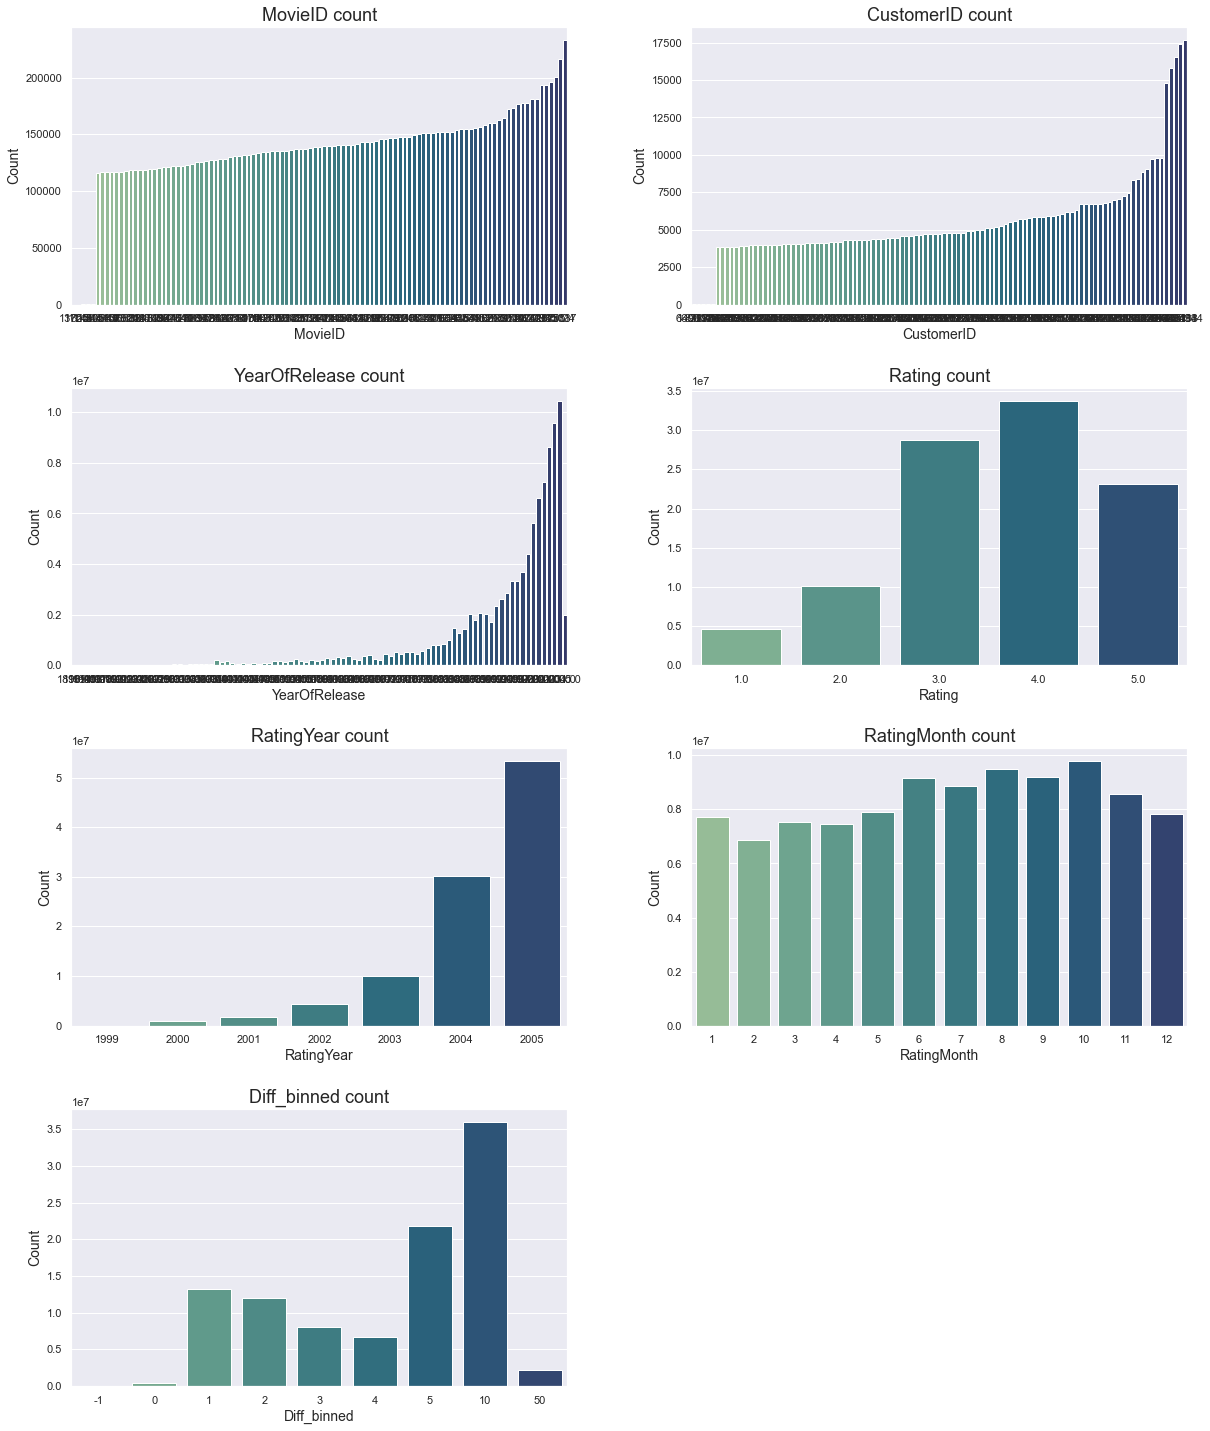

In [21]:
# Select columns to plot
cols_for_display = ["MovieID", 
                    "CustomerID", 
                    "YearOfRelease", 
                    "Rating", 
                    "RatingYear", 
                    "RatingMonth", 
                    "Diff_binned"
                   ]

plt.figure(figsize=(20, 25))
for i, col in enumerate(cols_for_display, 1):
    plt.subplot(4, 2, i)
    
    # Due to their large counts, prepare the ID columns different
    if col in ["CustomerID", "MovieID"]:
        counts = df.groupBy(col).count().orderBy("count").toPandas()
        cc = pd.concat([counts.head(), counts.tail(100)], ignore_index=True)
        
        sns.barplot(x=col, 
                    y="count", 
                    data=cc, 
                    order=cc.sort_values("count")[str(col)],
                    palette="crest")
    else:
        sns.barplot(x=col, 
                y="count", 
                data=df.groupBy(col).count().toPandas(),
                palette="crest")
      
    # Specify labels, title and their size
    plt.xlabel(col, size=14)
    plt.ylabel("Count", size=14)
    plt.title(f"{col} count", size=18)
    
plt.subplots_adjust(hspace=0.3, wspace=0.25)

Among other things, we learn the following from above plot:

- `MovieID` and `CustomerID` counts are highly skewed with some movies receiving many reviews and some customers giving many reviews. 
- Most movies are released recently. 
- Most movies have received a *3* or *4* in rating, but there are also many *5*s. *1*s are the rarest.
- Most movies were rated in 2004 and 2005, with over 50% of the ratings in 2005. 
- August, September and October are the most popular months to rate a moive. February the least. 
- Few movies are rated close to their release date (`Diff_binned` = 0). A lot of movies are rated the year after their release or within five years thereafter. *The interpretation of this last plot depends of course a lot on how we binned the column before. And as previously stated, binning is something that should be experimented with for best result.* 

<a name="ml-modelling"></a>

## [Machine Learning modelling](#top)


With a smaller dataset we would prefer to train and test many models using cross-validation. However, with over 100 million ratings, we can consider the data to be fairly large and will thus go with a more traditional train / test split. 80% of the data will be dedicated for training the model while 20% for testing it. Providing a `seed` will allow us to replicate the results.

In [13]:
# Split into train and test sets
splits = df.randomSplit([0.8, 0.2], seed=747)
df_train = splits[0]
df_test = splits[1]

In [14]:
# Display the first five rows on the train set
df_train.show(5)

+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+--------------------+--------------------+
|MovieID|CustomerID|Rating|RatingDate|YearOfRelease|RatingYear|RatingMonth|Diff_RatingRelease|Diff_binned|       HashedMovieID|    HashedCustomerID|
+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+--------------------+--------------------+
|      1|     13651|   3.0|2004-06-16|         2003|      2004|          6|               1.0|          1|(262144,[138338],...|(262144,[211647],...|
|      1|     14924|   5.0|2005-10-04|         2003|      2005|         10|               3.0|          3|(262144,[138338],...|(262144,[211647],...|
|      1|    145873|   3.0|2004-02-25|         2003|      2004|          2|               1.0|          1|(262144,[138338],...|(262144,[211647],...|
|      1|    188613|   4.0|2005-09-15|         2003|      2005|          9|               3.0|          3|

Specify target variable and features for modelling. Root Mean Squared Error (RMSE) will be used for evaluating the performance of the model. 

In [15]:
# Specify target variable
target = StringIndexer(inputCol="Rating", 
                       outputCol="label")

# Specify features
input_cols = ["YearOfRelease", 
              "MovieID", 
              "CustomerID",
              "RatingYear", 
              "RatingMonth", 
              "Diff_binned"]
featureAssembler = VectorAssembler(inputCols=input_cols, 
                                   outputCol="features")

# Specify evaluator with the default RMSE as metric
evaluator = RegressionEvaluator(metricName="rmse", 
                                predictionCol="prediction", 
                                labelCol="label")

<a name="baseline"></a>


### [Get baseline results with Linear Regression](#top)

To have something to compare with, we will train and evaluate one of the more simplistic algorithms on the data; Linear Regression, using its default parameters. 

Note that we do this on a smaller fraction of the data to speed things up (file `part-00000*.parquet`, which is around 2.5 million reviews). You can load it by changing the `data_path` [above](#data_path). 

```python
# Specify data path
data_path = "data-parquet/part-00000*.parquet"
```

In [14]:
%%time

# Instantiate a Linear regression model with default parameters
lr = LinearRegression()

# Put everything in a Pipeline
pipeline = Pipeline(stages=[target, featureAssembler, lr])

# Train the model
baseline = pipeline.fit(df_train)

CPU times: user 24.6 ms, sys: 8.59 ms, total: 33.2 ms
Wall time: 34.7 s


In [16]:
def evaluate_model(model, trainSet, testSet):
    """ Function for evaluating a model on a train and test set"""
    
    # Evaluate model on train set
    pred_train = model.transform(trainSet)
    rmse_train = evaluator.evaluate(pred_train, {evaluator.metricName: "rmse"})

    # Evaluate model on test set
    pred_test = model.transform(testSet)
    rmse_test = evaluator.evaluate(pred_test, {evaluator.metricName: "rmse"})
    
    # Display results
    time.sleep(1)
    print(f"RMSE train set: {rmse_train:.5f}")
    print(f"RMSE test set:  {rmse_test:.5f}")
    
    return rmse_train, rmse_test

In [16]:
# Evaluate baseline model
rmse_train, rmse_test = evaluate_model(baseline, df_train, df_test)

RMSE train set: 1.15156
RMSE test set:  1.15247


A baseline of 1.152 is achieved on the test set. There's practically no difference between the train and test sets, which means variance is low. 

> After evaluating a model using the original `CustomerID` and `MovieID` features instead of the hashed alternatives, `HashedCustomerID` and `HashedMovieID`, I found practically no differences between the two. I will thus go with the original features, and you will simply have to take my words for it. :)


<a name="regressors"></a>


### [Tune and Evaluate Multiple Regressors](#top)


In order to find the best model for the problem, we will evaluate several standard algorithms. Train, tune and evaluate Decision Trees, Random Forest, Gradient-Boosted Trees and Linear Regressors on the dataset. 

In [17]:
%%time

# Specify regressors to evaluate
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
gb = GBTRegressor()
lr = LinearRegression()

regressors = [{"regressor": dt,
               "paramGrid": ParamGridBuilder().addGrid(dt.maxBins, [16, 32]) \
                                              .addGrid(dt.maxDepth, [3, 5, 7]) \
                                              .build()},
              {"regressor": rf,
               "paramGrid": ParamGridBuilder().addGrid(rf.numTrees, [20, 40, 60]) \
                                              .addGrid(rf.maxDepth, [3, 5]) \
                                              .build()},
              {"regressor": gb,
               "paramGrid": ParamGridBuilder().addGrid(gb.subsamplingRate, [1.0, 0.7]) \
                                              .addGrid(gb.maxDepth, [3, 5]) \
                                              .build()},
              {"regressor": lr,
               "paramGrid": ParamGridBuilder().addGrid(lr.maxIter, [100, 1000]) \
                                              .addGrid(lr.regParam, [0.0, 0.01, 0.1]) \
                                              .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
                                              .build()}
             ]

results = {}
for regressor in regressors:
    name = str(regressor["regressor"]).split("_")[0]
    print(f"\nTuning {name}")
    
    # Create Pipeline
    pipeline = Pipeline(stages=[target, featureAssembler, regressor["regressor"]])
    
    # Specify model training specs
    tvs = TrainValidationSplit(estimator=pipeline, 
                               estimatorParamMaps=regressor["paramGrid"], 
                               evaluator=evaluator,
                               trainRatio=0.75,
                               parallelism=8, 
                               seed=72)
    
    # Train model
    model = tvs.fit(df_train)
    
    # Evaluate model
    rmse_train, rmse_test = evaluate_model(model, df_train, df_test)
    
    # Store the results
    results[name] = {"model": model,
                     "rmse_train": rmse_train,
                     "rmse_test": rmse_test}


Tuning DecisionTreeRegressor


RMSE train set: 1.14973
RMSE test set:  1.15098

Tuning RandomForestRegressor


RMSE train set: 1.15065
RMSE test set:  1.15171

Tuning GBTRegressor


RMSE train set: 1.14881
RMSE test set:  1.15005

Tuning LinearRegression


RMSE train set: 1.15156
RMSE test set:  1.15247
CPU times: user 2.29 s, sys: 897 ms, total: 3.18 s
Wall time: 10min 56s


Although with a very small margin, the Gradient-Boosted Tree Regressor (GBTRegressor) is the most performant model on the test data. Let's extract the best parameters and train it on the entire dataset. 

In [20]:
# Get the best GBTR parameters
best_gbtr = results["GBTRegressor"]["model"].bestModel
maxDepth = best_gbtr.stages[-1]._java_obj.getMaxDepth()
subSamplingsRate = best_gbtr.stages[-1]._java_obj.getSubsamplingRate()

print("maxDepth:        ", maxDepth)
print("subSamplingsRate:", subSamplingsRate)

maxDepth:         5
subSamplingsRate: 0.7



<a name="best_model"></a>


## [Train the Best GBTRegressor on the Full Dataset](#top)


Train the GBTRegressor on the entire dataset using the best parameters. Load the entire dataset by updating [above](#data_path) code to the following:  


```python
# Specify data path
data_path = "data-parquet/part-0*.parquet"
```

In [17]:
%%time

# Specify model parameters from previous step
gb_best = GBTRegressor(maxDepth=5,
                       subsamplingRate=0.7)

# Put everything in a Pipeline
pipeline = Pipeline(stages=[target, featureAssembler, gb_best])

# Train model
final_model = pipeline.fit(df_train)

CPU times: user 1.31 s, sys: 1.54 s, total: 2.85 s
Wall time: 1h 25min 23s


In [18]:
# Evaluate the model
best_rmse_train_, best_rmse_test = evaluate_model(final_model, df_train, df_test)

RMSE train set: 1.14898
RMSE test set:  1.14893


We have a final score of 1.149 on the test set. It's barely better than the 1.152 baseline though, and significantly worse than the 0.8572 the team who won the challenge in 2009 got. 

Let's further explore which of the features are most important for the model to make its predicitons. 

<a name="feature_importance"></a>


## [Which Features are most Important?](#top)

The most important features are `YearOfRelease`, `MovieID` and `RatingMonth`, contributing 37, 27 and 20%, respectively, as displayed in the plot below. The difference between the release and rating year, `Diff_binned` contributes a meek 3% to the overall, while `CustomerID` less than 1 percent. 

This means that it matters little *who* rated the movie and far more *which* movie it is. This is reasonable as one would expect that most people would rate a good movie as good and a bad one as bad. 

However, that the release year matters this much is quite surprising. We would need to dig deeper into the data to find out why this may be the case. We won't do that here, but can speculate that, perhaps, older movies are held to newer standards, and since all ratings are from 1999 and later, while some movies are 100 years older than that, their ratings might be biased by this. Who hasn't re-watched a favourite movie from childhood and found it awful at later years? Or perhaps, newer movies might simply be better than older? 

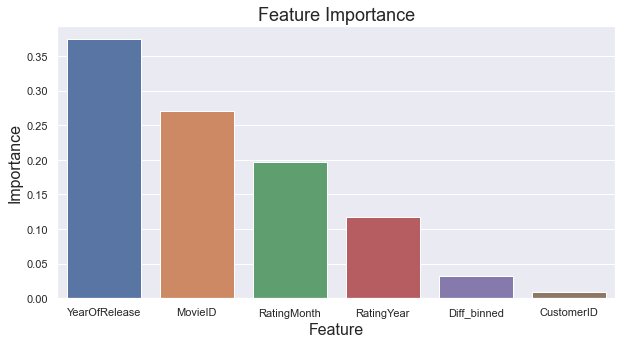

In [19]:
# Plot and rank the features in importance
importance = pd.DataFrame(zip(final_model.stages[-1].featureImportances.toArray(), 
                              input_cols),
                         columns=["Importance", "Feature"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Feature",
            y="Importance", 
            data=importance,
            order=importance.sort_values("Importance", 
                                         ascending=False)["Feature"])

plt.xlabel("Feature", size=16)
plt.ylabel("Importance", size=16)
plt.title("Feature Importance", size=18);

<br>

<a name="conclusions"></a>

## [Conclusions](#top)

We've trained a few models on the 100 million ratings dataset obtained from the Netflix challenge back in 2009 using nothing but a laptop. Although the model performance isn't as good as what was attained by the winning teams (they [reportedly](https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429) spent 2,000 hours during the first year of the competition), we've been successful in training a fairly large dataset locally. This in less time than what it takes to return from an outdoor exercise session.

A final score of 1.149 RMSE (interpreted as 1.149 points off, on average) was achieved while identifying release year, movie ID and rating month to be the most important features when predicting a movie's rating. This is not to say that other features wouldn't be important in making this prediction, but rather that out of the features available in the dataset, these are the most important. 

We only briefly covered feature engineering - the process of creating new features out of current or external data - but this is often an incredibly important aspect in machine learning with significant predictive benefits. Examples of engineered features can be the average rating per movie or year, or count/average of ratings per day and movie, number of days since a customer's first rating, and many more. 